In [50]:
%%time
import gdal
import rasterio
from rasterio.plot import show, show_hist
import numpy as np
import cupy as cp #  GPU ACCELERATION
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
from lxml import etree
from io import BytesIO
from skimage import exposure
# glymur for jp2.., return glymur.Jp2k(filename)[:]
gdal.UseExceptions()

Wall time: 0 ns


### Utility functions

In [20]:
def print_meta_data(data, arguments):
    for arg in arguments:
        print(arg, ":", data[arg])

def rescale_intensity(image, _min, _max):
    return exposure.rescale_intensity(image, in_range=(_min, _max), out_range=(0, 255)).astype(np.uint8)
    

## Load data

In [4]:
root = "../data/"

In [5]:
dataset_1 = root + "S2A_MSIL2A_20200912T100031_N0214_R122_T33UXR_20200912T114911.SAFE/"

## Explore data

#### XML data

In [6]:
MTD_MSIL2A = dataset_1 + "MTD_MSIL2A.xml"

In [7]:
MTD_MSIL2A_data = gdal.Open(MTD_MSIL2A)
MTD_MSIL2A_data.GetMetadata()
# print_meta_data(MTD_MSIL2A_data.GetMetadata(), args)
# MTD_MSIL2A_data.GetMetadata()

{'AOT_QUANTIFICATION_VALUE': '1000.0',
 'AOT_QUANTIFICATION_VALUE_UNIT': 'none',
 'AOT_RETRIEVAL_ACCURACY': '0.0',
 'BOA_QUANTIFICATION_VALUE': '10000',
 'BOA_QUANTIFICATION_VALUE_UNIT': 'none',
 'CLOUD_COVERAGE_ASSESSMENT': '11.340936',
 'CLOUD_SHADOW_PERCENTAGE': '7.01378',
 'DARK_FEATURES_PERCENTAGE': '1.060481',
 'DATATAKE_1_DATATAKE_SENSING_START': '2020-09-12T10:00:31.024Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20200912T100031_027289_N02.14',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '122',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0.0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((16.411349506049252 50.543739174288454, 17.95938607628957 50.5146700159563, 17.899359688454204 49.52841829443089, 16.382684363173013 49.55649445196309, 16.411349506049252 50.543739174288454))',
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME':

In [8]:
datasets = MTD_MSIL2A_data.GetMetadata('SUBDATASETS')
# print(datasets)
print("Datasets\n")
for i in range(4):
    print(datasets['SUBDATASET_%d_DESC' % (i+1)])
    print("Files:", end=" ")
    print(datasets['SUBDATASET_%d_NAME' % (i+1)] + "\n")

Datasets

Bands B2, B3, B4, B8 with 10m resolution, UTM 33N
Files: SENTINEL2_L2A:../data/S2A_MSIL2A_20200912T100031_N0214_R122_T33UXR_20200912T114911.SAFE/MTD_MSIL2A.xml:10m:EPSG_32633

Bands B5, B6, B7, B8A, B11, B12 with 20m resolution, UTM 33N
Files: SENTINEL2_L2A:../data/S2A_MSIL2A_20200912T100031_N0214_R122_T33UXR_20200912T114911.SAFE/MTD_MSIL2A.xml:20m:EPSG_32633

Bands B1, B9 with 60m resolution, UTM 33N
Files: SENTINEL2_L2A:../data/S2A_MSIL2A_20200912T100031_N0214_R122_T33UXR_20200912T114911.SAFE/MTD_MSIL2A.xml:60m:EPSG_32633

True color image, UTM 33N
Files: SENTINEL2_L2A:../data/S2A_MSIL2A_20200912T100031_N0214_R122_T33UXR_20200912T114911.SAFE/MTD_MSIL2A.xml:TCI:EPSG_32633



### Raster data

In [9]:
raster_data = dataset_1 + 'GRANULE/L2A_T33UXR_A027289_20200912T100044/IMG_DATA/'

##### Creating True color image

In [95]:
# No need to do this if we use our aux data but I prefer do it this way
original_tci = raster_data + 'R60m/T33UXR_20200912T100031_TCI_60m.jp2'
red_band = raster_data + 'R60m/T33UXR_20200912T100031_B04_60m.jp2'
green_band = raster_data + 'R60m/T33UXR_20200912T100031_B03_60m.jp2'
blue_band = raster_data + 'R60m/T33UXR_20200912T100031_B02_60m.jp2'

# Open images (with rasterio lib-build on top of GDAL), these are 16bit grayscale images (MSI Sensor is 12bit)
red_image = rasterio.open(red_band)
green_image = rasterio.open(green_band)
blue_image = rasterio.open(blue_band)

assert(red_image.count == green_image.count == blue_image.count) # 1 band each
# Load raster bands
red = red_image.read(1)
green = green_image.read(1)
blue = blue_image.read(1)

In [96]:
rgb_profile = red_image.profile
rgb_profile['dtype'] = 'uint8'
rgb_profile['count'] = 3
rgb_profile['photometric'] = "RGB"
rgb_profile['driver'] = "GTiff"
rgb_profile['interleave'] = "PIXEL"
rgb_profile['photometric'] = "YCBCR"
rgb_profile['compress'] = "JPEG"
rgb_profile['blockxsize'] = 256
rgb_profile['blockysize'] = 256
rgb_profile['nodata'] = 0

In [97]:
# Final rgb image would be too 'dark', normalize the values first
rgb = [red, green, blue]
gain = 1.2

rgb[0] = rescale_intensity(rgb[0] * gain, 0, 4096) 
rgb[1] = rescale_intensity(rgb[1] * gain, 0, 4096)
rgb[2] = rescale_intensity(rgb[2] * gain, 0, 4096)

In [98]:
with rasterio.open("rgb.tif", 'w', **rgb_profile) as dst:
    for count,band in enumerate(rgb,1):
        dst.write(band, count)

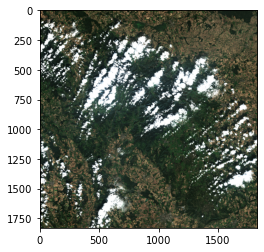

<AxesSubplot:>

In [56]:
show(rgb)

### NDVI

In [61]:
red_band = raster_data + 'R60m/T33UXR_20200912T100031_B04_60m.jp2'
nir_band = raster_data + 'R60m/T33UXR_20200912T100031_B8A_60m.jp2'

In [62]:
%%time
with rasterio.open(red_band) as red:
    red = red.read()
with rasterio.open(nir_band) as nir:
    nir = nir.read()

Wall time: 500 ms


In [63]:
%%time
ndvi1 = (nir.astype(float) - red.astype(float))
ndvi2 = (nir+red)
ndvi = np.divide(ndvi1, ndvi2, out=np.zeros_like(ndvi1), where=ndvi2!=0)
ndvi = ndvi.squeeze()

Wall time: 52 ms


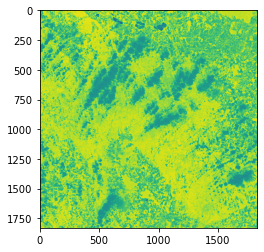

<AxesSubplot:>

In [69]:
show(ndvi)

In [70]:
# RANDOM

In [87]:
profile = rasterio.open(red_band).profile
profile.update(dtype='float64')
profile['count'] = 3
profile['photometric'] = "RGB"
profile['driver'] = "GTiff"

In [72]:
%%time
red = np.copy(ndvi)
green = np.copy(ndvi)
blue = np.copy(ndvi)

Wall time: 31 ms


In [73]:
vals = [-0.2, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]
redd = [0, 165, 215, 244, 253, 254, 255, 217, 166, 102, 26, 0]
greenn = [0, 0, 48, 109, 174, 224, 255, 239, 217, 189, 152, 104]
bluee = [0, 38, 39, 67, 97, 139, 191, 139, 106, 99, 80, 55]

In [74]:
%%time
# I AM SORRY FOR THE NEXT LINES OF CODE :( .
red[red<(-0.2)] = 0
red[(red>=(-0.2))&(red<=0)] = 165
red[(red>.0)&(red<=.1)] = 215
red[(red>.1)&(red<=.2)] = 244
red[(red>.2)&(red<=.3)] = 253
red[(red>.3)&(red<=.4)] = 254
red[(red>.4)&(red<=.5)] = 255
red[(red>.5)&(red<=.6)] = 217
red[(red>.6)&(red<=.7)] = 166
red[(red>.7)&(red<=.8)] = 102
red[(red>.8)&(red<=.9)] = 26
red[(red>.9)&(red<=1)] = 0

Wall time: 159 ms


In [75]:
%%time
green[green<(-0.2)] = 0
green[(green>=(-0.2))&(green<=0)] = 0
green[(green>.0)&(green<=.1)] = 48
green[(green>.1)&(green<=.2)] = 109
green[(green>.2)&(green<=.3)] = 174
green[(green>.3)&(green<=.4)] = 224
green[(green>.4)&(green<=.5)] = 255
green[(green>.5)&(green<=.6)] = 239
green[(green>.6)&(green<=.7)] = 217
green[(green>.7)&(green<=.8)] = 189
green[(green>.8)&(green<=.9)] = 152
green[(green>.9)&(green<=1)] = 104

Wall time: 156 ms


In [76]:
blue[blue<(-0.2)] = 0
blue[(blue>=(-0.2))&(blue<=0)] = 38
blue[(blue>.0)&(blue<=.1)] = 39
blue[(blue>.1)&(blue<=.2)] = 67
blue[(blue>.2)&(blue<=.3)] = 97
blue[(blue>.3)&(blue<=.4)] = 139
blue[(blue>.4)&(blue<=.5)] = 191
blue[(blue>.5)&(blue<=.6)] = 139
blue[(blue>.6)&(blue<=.7)] = 106
blue[(blue>.7)&(blue<=.8)] = 99
blue[(blue>.8)&(blue<=.9)] = 80
blue[(blue>.9)&(blue<=1)] = 55

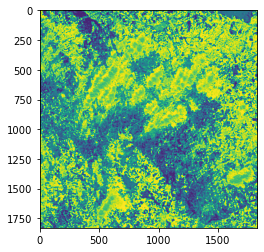

<AxesSubplot:>

In [77]:
show(red)

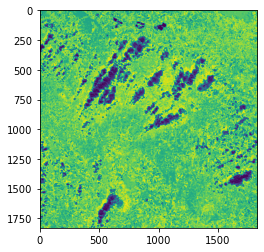

<AxesSubplot:>

In [80]:
show(green)

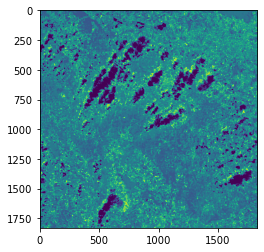

<AxesSubplot:>

In [81]:
show(blue)

### NDVI CLOUD MASK

In [89]:
# Detecting clouds with low ndvi is good only above area with vegetation (obviously)

In [90]:
ndvi = ndvi.squeeze()

In [91]:
mask = np.where(ndvi<=.1, 0, 1).astype('uint8')

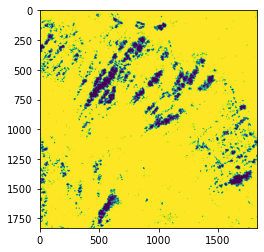

<AxesSubplot:>

In [93]:
show(mask)

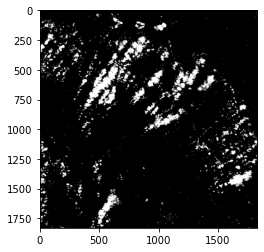

In [94]:
plt.imshow(mask, cmap='binary')